## Simulate tokamak plasma and make matrix and vector for tomography(d = Rf) 

In [1]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import math
import numpy as np
import sympy
from sympy import *

F_DIM = 64  # resolution of reconstructed image (F_DIM × F_DIM)
D_DIM = 12  # resolution of detector camera (D_DIM × D_DIM)

In [2]:
class MakeMatrix:
    def __init__(self, sx, sy, fx, fy):
        self.R = 1.8
        self.a = 0.45
        m = 4
        n = 2
        self.onesteplen = 0.01
        self.screen_center = np.array([sx, sy, 0.])
        self.focus_position = np.array([fx, fy, 0.])
        self.screen_len = 0.12
        self.sightline = self.mkscreen()
        self.projection_angle = self.get_projectionangle()
        self.f_psi, self.get_psi = self.psi_eq()
        self.get_emission = self.emission_eq(m, n)

    def mkscreen(self):
        '''Make detector screen'''
        pixel = self.screen_len / D_DIM
        screen_pos_list = []
        x, y, z, t, x_c, y_c = symbols("x y z t x_c y_c", real=True)
        center_line_u = (self.focus_position - self.screen_center) / \
            np.linalg.norm(self.focus_position - self.screen_center, ord=2)
        plane_eq = center_line_u[0] * (x - self.screen_center[0]) + center_line_u[1] * (
            y - self.screen_center[1]) + center_line_u[2] * (z - self.screen_center[2])
        hori_eq = sqrt((x - x_c)**2 + (y - y_c)**2) - pixel * t
        vertical_eq1 = sqrt(
            (x - self.screen_center[0])**2 + (y - self.screen_center[1])**2 + (z)**2) - pixel * t
        xv = y * self.screen_center[0] / self.screen_center[1]
        yv_eq, zv_eq = solve(
            [vertical_eq1.subs(x, xv), plane_eq.subs(x, xv)], [y, z])[0]
        xh_eq, yh_eq = solve([hori_eq, plane_eq], [x, y])[0]

        for i in range(-int(D_DIM / 2), int(D_DIM / 2)):
            x_ = y * self.screen_center[0] / self.screen_center[1]
            if i == 0:
                x_, y_, z_ = self.screen_center
            else:
                y_ = yv_eq.subs(t, np.abs(i))
                z_ = zv_eq.subs(t, np.abs(i))
                z_ = self.screen_center[2] + np.sign(i) * z_
                x_ = x_.subs(y, y_)
            for j in range(-int(D_DIM / 2), int(D_DIM / 2)):
                if j == 0:
                    x_plus = x_
                    y_plus = y_
                else:
                    x_plus = xh_eq.subs(
                        [(x_c, x_), (y_c, y_), (z, z_), (t, np.abs(j))])
                    y_plus = yh_eq.subs(
                        [(x_c, x_), (y_c, y_), (z, z_), (t, np.abs(j))])
                if j < 0:
                    x_minus = x_ - (x_plus - x_)
                    y_minus = y_ - (y_plus - y_)
                    screen_pos_list.append(
                        np.array([float(re(x_minus)), float(re(y_minus)), float(re(z_))]))
                else:
                    screen_pos_list.append(
                        np.array([float(re(x_plus)), float(re(y_plus)), float(re(z_))]))

        screen_pos_list = np.array(screen_pos_list)
        sightline_list = self.focus_position[None, :] - screen_pos_list
        self.screen_pos_list = screen_pos_list
        sightline_list = sightline_list / \
            np.sqrt(np.einsum('ij,ij->i', sightline_list,
                              sightline_list))[:, None]
        return sightline_list

    def show_screen(self):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel("x", size=14)
        ax.set_ylabel("y", size=14)
        ax.set_zlabel("z", size=14)
        ax.plot(self.screen_pos_list[:,
                                     0],
                self.screen_pos_list[:,
                                     1],
                self.screen_pos_list[:,
                                     2],
                '.')
        plt.show()

    def psi_eq(self):
        '''
        magnetic flux surface equation
        '''
        x, y, psi = symbols('x y psi', real=True)
        mu = 1.26
        I_p = 0.1
        lam = 0.001
        # gs = mu*I_p*self.R/2*pi*(ln(8*self.R/x) - 2) - ((mu*I_p/4*pi) *
        #                                                 (ln(x/self.a) + (lam + 0.5)*(1-self.a**2/x**2)))*x*cos(y) - psi
        '''for cylinder tokamak '''
        gs = ((x * cos(y))**2 + (x * sin(y))**2 + 1.)**4 - psi
        gs_psi = solve(gs, psi)[0]
        get_psi = lambdify((x, y), gs_psi, 'numpy')
        f_psi = lambdify((x, y, psi), gs, 'numpy')
        return f_psi, get_psi

    def emission_eq(self, m, n):
        '''
        emission profile equation
        '''
        x, y = symbols('x y', real=True)
        '''tearing parity'''
        l = 0.06
        mu = 0.02
        mm = 0.3
        emission1 = +exp(-l * (abs(x - mm) - mu)**2 / (2 * abs(x - mm)
                         * mu**2)) * cos(m * y)  # * abs(sqrt(1/(x-0.3)**3))
        emission2 = -exp(-l * (abs(x - mm) - mu)**2 / (2 * abs(x - mm)
                         * mu**2)) * cos(m * y)  # * abs(sqrt(1/(x-0.3)**3))
        expr = Piecewise((emission1, (x > mm)),
                         (emission2, (x <= mm)))
        # expr = exp(-((x-0.)/0.3)**2)
        f_emission = lambdify((x, y), expr, 'numpy')
        return f_emission

    def emission_eq_circle(self, m, n):
        '''
        emission profile for making mask
        '''
        x, y = symbols('x y', real=True)
        expr = exp(-((x - 0.3) / 0.1)**2) * sign(x - 0.2)
        f_emission = lambdify((x, y), expr, 'numpy')
        return f_emission

    def get_projectionangle(self):
        x, y, px, py, sx, sy, ox, oy = sympy.symbols("x y px py sx sy ox oy")
        eq1 = py + (sy - py) / (sx - px) * (x - px) - y
        eq2 = oy - (sx - px) / (sy - py) * (x - ox) - y
        solution = solve([eq1, eq2], [x, y])
        center = np.array([0., 0.])
        qx = float(solution[x].subs([(px,
                                      self.screen_center[0]),
                                     (py,
                                      self.screen_center[1]),
                                     (sx,
                                      self.focus_position[0]),
                                     (sy,
                                      self.focus_position[1]),
                                     (ox,
                                      center[0]),
                                     (oy,
                                      center[1])]))
        qy = float(solution[y].subs([(px,
                                      self.screen_center[0]),
                                     (py,
                                      self.screen_center[1]),
                                     (sx,
                                      self.focus_position[0]),
                                     (sy,
                                      self.focus_position[1]),
                                     (ox,
                                      center[0]),
                                     (oy,
                                      center[1])]))
        theta_cross = self.arctan(qy, qx)
        return theta_cross

    def safety_factor(self, psi):
        '''
        safety factor equation
        '''
        return psi**2

    def gs_bisection(self, psi, omega):
        '''
        calculate radius from magnetic surface and angle by bisection method
        '''
        r1 = self.a * 1.5
        r0 = 0.02
        r0 = np.full(psi.shape[0], r0)
        r1 = np.full(psi.shape[0], r1)
        for _ in range(60):
            x0 = self.f_psi(r0, omega, psi)
            x1 = self.f_psi(r1, omega, psi)
            x01 = self.f_psi((r1 + r0) / 2, omega, psi)
            r0 = np.where((np.sign(x0) == np.sign(x01)), (r1 + r0) / 2, r0)
            r1 = np.where((np.sign(x1) == np.sign(x01)), (r1 + r0) / 2, r1)
            if np.mean(r1 - r0) < 1 * 10**(-5):
                break
        return np.where(((r1 - r0) > 10**(-4)) |
                        (np.isnan(r1 + r0)), 0.02, (r1 + r0) / 2)

    def get_omega(self, psi, omega, angle_diff):
        '''
        calculate angle difference between target poloidal cross section and current position
        '''
        omega_diff = angle_diff / self.safety_factor(psi)
        omega_diff = omega_diff % (2 * np.pi)
        return omega_diff + omega

    def sight_step(self, i, return_emission=False):
        # cylindrical coordinate
        sight_pos = self.focus_position + \
            self.sightline * (i * self.onesteplen)
        angle_diff = -self.arctan(
            sight_pos[:, 1], sight_pos[:, 0]) + self.projection_angle
        r = np.sqrt(sight_pos[:, 0]**2 + sight_pos[:, 1]**2)

        # tokamak coordinate
        omega = self.arctan(sight_pos[:, 2], r - self.R)
        rho_old = np.sqrt((r - self.R)**2 + sight_pos[:, 2]**2)
        mask = np.where((rho_old < self.a), True, False)
        if np.count_nonzero(mask) != 0:
            psi = self.get_psi(rho_old[mask], omega[mask])
            new_omega = self.get_omega(psi, omega[mask], angle_diff[mask])
            new_rho = rho_old[mask] # when magnetic surface is cylinder, radius does not change 
            # new_rho = self.gs_bisection(psi, new_omega)
            self.mask = mask
            if return_emission:
                emission = self.get_emission(new_rho, new_omega)
                return emission * self.onesteplen
            else:
                return new_omega, new_rho,
        else:
            return False, False

    def show_psi(self):
        '''
        show magnetic flux surface
        '''
        rho = np.linspace(0, self.a, 120)
        omega = np.linspace(0, 2 * np.pi, 120)
        Rho, Omega = np.meshgrid(rho, omega)
        X = self.R + Rho * np.cos(Omega)
        Z = Rho * np.sin(Omega)
        plt.figure()
        Psi = self.get_psi(Rho, Omega)
        plt.ylabel("Height (m)")
        plt.xlabel("Major radius (m)")
        cont = plt.contour(
            X,
            Z,
            Psi,
            8,
            linewidths=(
                2,
                1,
                2,
                1,
                2,
                1,
                1),
            colors=(
                'r',
                'k',
                'b',
                'k',
                'g',
                'k',
                'k'), zorder=10)
        plt.gca().set_aspect('equal', adjustable='box')
        cont.collections[1].set_label("magnetic surface")
        N = 25
        xs = np.linspace(1.35, 2.25, N)
        ys = np.linspace(-0.45, 0.45, N)
        for x, y in zip(xs, ys):
            plt.axvline(x=x, linewidth=0.5, color='k', alpha=0.3)
            plt.axhline(y=y, linewidth=0.5, color='k', alpha=0.3)
        plt.xlim([1.35, 2.25])
        plt.ylim([-0.45, 0.45])
        plt.legend(loc='upper right').set_zorder(102)
        plt.show()

    def save_emission(self):
        '''
        save f
        '''
        x = np.linspace(-self.a, self.a, F_DIM)
        y = np.linspace(-self.a, self.a, F_DIM)
        X, Y = np.meshgrid(x, y)
        Rho = np.sqrt(X**2 + Y**2)
        Omega = np.arctan2(Y, X)
        get_emission = self.emission_eq_circle(0, 0)
        Psi = get_emission(Rho, Omega)
        np.save(f"ls_image_{F_DIM}", self.minmax_normalize(Psi))
        Psi2 = self.get_emission(Rho, Omega)
        max_f = np.max(Psi2)
        X = self.R + Rho * np.cos(Omega)
        Z = Rho * np.sin(Omega)
        plt.figure(figsize=(5, 5))
        plt.pcolor(X, Z, Psi2, cmap="bwr", vmax=max_f, vmin=-max_f)
        rho = np.linspace(0, self.a, 64)
        omega = np.linspace(0, 2 * np.pi, 64)
        Rho, Omega = np.meshgrid(rho, omega)
        X = self.R + Rho * np.cos(Omega)
        Z = Rho * np.sin(Omega)
        Psi = self.get_psi(Rho, Omega)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.ylabel("Height (m)")
        plt.xlabel("Major radius (m)")
        plt.colorbar(orientation="horizontal", shrink=0.65)
        cont = plt.contour(X, Z, Psi, 8, colors='black', alpha=0.3)
        cont.collections[1].set_label("magnetic surface")
        plt.legend()
        plt.show()
        np.save(f"f_{F_DIM}", Psi2)

    def show_q(self):
        x = np.linspace(0, self.a, 100)
        theta = np.zeros(100)
        psi = self.get_psi(x, theta)
        plt.figure()
        plt.plot(x / self.a, self.safety_factor(psi))
        plt.ylim((0, 6))
        plt.xlabel("normalized poloidal flux")
        plt.ylabel(r"safety factor $q$")
        plt.show()

    def arctan(self, y, x):
        out = np.arctan2(y, x)
        return out

    def minmax_normalize(self, x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))


In [3]:
'''screen_center(1.8, 2.0), focus position(1.8, 1.8)'''
MM = MakeMatrix(1.8, 2., 1.8, 1.8)

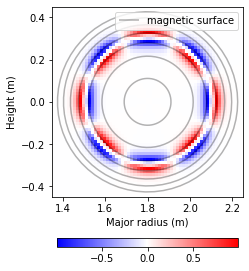

In [4]:
'''save ls_image'''
MM.save_emission()

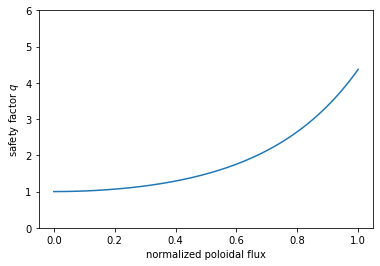

In [5]:
'''show q profile'''
MM.show_q()

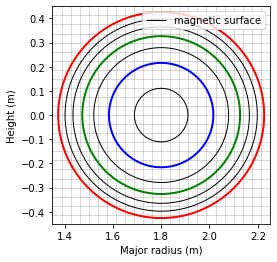

In [6]:
'''show magnetic flux surface'''
MM.show_psi()

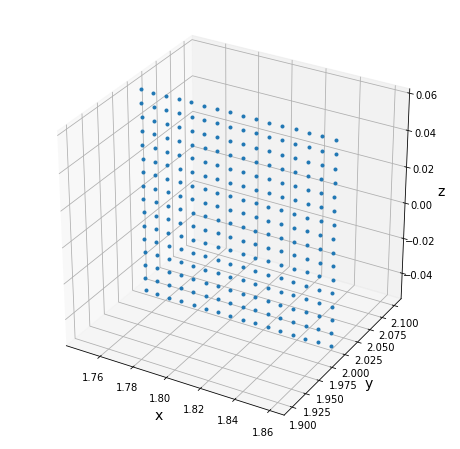

In [7]:
'''show screen sensor'''
MM.show_screen()

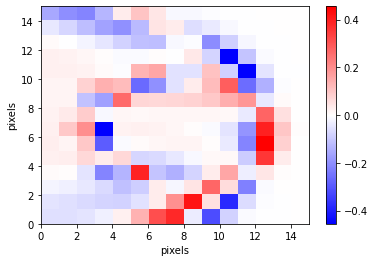

In [8]:
'''Save detector image'''
screen = np.zeros(D_DIM**2)
flag = np.full(D_DIM**2, False)
rmlist = np.full(D_DIM**2, False)
temp = np.full(D_DIM**2, 0.)
for i in range(0, math.ceil(MM.R * 2.5 / MM.onesteplen)):
    emission = MM.sight_step(i, return_emission=True)
    if np.any(emission):
        # print(f"ON:{i}")
        rmlist[np.where((flag) & (MM.mask == False))] = True
        flag[MM.mask] = True
        temp[MM.mask] = emission
        screen[np.where((rmlist == False) & (MM.mask == True))
               ] += temp[np.where((rmlist == False) & (MM.mask == True))]

x = [i for i in range(D_DIM)]
z = [i for i in range(D_DIM)]
plt.pcolormesh(x[::-1], z[::-1], screen.reshape(D_DIM, D_DIM)[:, ::-1],
               cmap='bwr', norm=Normalize(vmin=-np.max(screen), vmax=np.max(screen)))
plt.xlabel("pixels")
plt.ylabel("pixels")
plt.colorbar()
np.save(f"d_{D_DIM}", screen)

In [9]:
'''Get sight line'''
r_list = []
z_list = []
r_plot_list = []
z_plot_list = []
mask_list = []
flag = np.full(D_DIM**2, False)
rmlist = np.full(D_DIM**2, False)
omega_temp = np.full(D_DIM**2, 0.0)
rho_temp = np.full(D_DIM**2, 0.0)
for i in range(0, math.ceil(MM.R * 2.5 / MM.onesteplen)):
    new_omega, new_rho = MM.sight_step(i)
    if np.any(new_omega == False) == False:
        rmlist[np.where((flag) & (MM.mask == False))] = True
        flag[MM.mask] = True
        omega_temp[MM.mask] = new_omega
        rho_temp[MM.mask] = new_rho
        new_omega = omega_temp[np.where((rmlist == False) & (MM.mask == True))]
        new_rho = rho_temp[np.where((rmlist == False) & (MM.mask == True))]
        r = np.sign(np.cos(MM.projection_angle)) * MM.R - \
            np.sign(np.cos(MM.projection_angle)) * new_rho * np.cos(new_omega)
        z = new_rho * np.sin(new_omega)
        r_list.append(r)
        z_list.append(z)
        r_plot_list.append(r)
        z_plot_list.append(z)
        MM.mask[rmlist] = False
        mask_list.append(MM.mask)
r_list = np.array(r_list).T
z_list = np.array(z_list).T

ipykernel_launcher:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
ipykernel_launcher:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


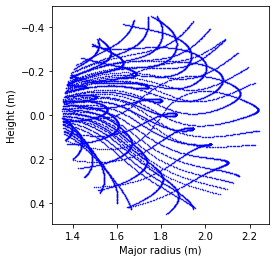

In [10]:
'''Show sight line'''
plt.figure()
plot_list_r = []
plot_list_z = []
for r, z, mask in zip(r_plot_list, z_plot_list, mask_list):
    r_p = np.full(D_DIM**2, MM.R)
    z_p = np.zeros(D_DIM**2)
    if r.shape != r_p[mask].shape:
        continue
    r_p[mask] = r
    z_p[mask] = z
    plot_list_r.append(r_p)
    plot_list_z.append(z_p)
plot_list_r = np.array(plot_list_r)
plot_list_z = np.array(plot_list_z)
for i in range(plot_list_r.shape[1]):
    if i % 5 == 0:
        out_r = plot_list_r[:, i][np.where(plot_list_r[:, i] != 1.8)]
        out_z = plot_list_z[:, i][np.where(plot_list_z[:, i] != 0.)]
        plt.plot(out_r, out_z, '.', color='b', markersize=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.ylabel("Height (m)")
plt.xlabel("Major radius (m)")
plt.show()

In [11]:
'''Transfer sight line to poloidal cross section'''
r = np.linspace(
    np.sign(
        np.cos(
            MM.projection_angle)) *
    MM.R -
    MM.a,
    np.sign(
        np.cos(
            MM.projection_angle)) *
    MM.R +
    MM.a,
    F_DIM +
    2)
z = np.linspace(-MM.a, MM.a, F_DIM + 2)
projection_mat = np.zeros((D_DIM**2, F_DIM, F_DIM))
rr, zz = np.meshgrid(r, z)
A = np.dstack([rr, zz]).reshape(-1, 2)
B = np.dstack([np.roll(rr, 1, axis=1), zz]).reshape(-1, 2)
C = np.dstack([np.roll(rr, 1, axis=1), np.roll(zz, -1, axis=0)]).reshape(-1, 2)
D = np.dstack([rr, np.roll(zz, -1, axis=0)]).reshape(-1, 2)
view_mat = np.zeros((F_DIM, F_DIM))
for r, z, mask in zip(r_list, z_list, mask_list):
    if r.shape[0] == 0:
        continue
    pos = np.array(list(zip(r, z)))
    Atopos = pos[:, None, :] - A[None, :, :]
    Btopos = pos[:, None, :] - B[None, :, :]
    Ctopos = pos[:, None, :] - C[None, :, :]
    Dtopos = pos[:, None, :] - D[None, :, :]
    C1 = np.sign(np.cross(Atopos, (B - A)))
    C2 = np.sign(np.cross(Btopos, (D - B)))
    C3 = np.sign(np.cross(Dtopos, (A - D)))
    tri1_flag = np.where((C1 == C2) & (C1 == C3), True, False)
    C1 = np.sign(np.cross(Atopos, (C - B)))
    C2 = np.sign(np.cross(Btopos, (D - C)))
    C3 = np.sign(np.cross(Dtopos, (B - D)))
    tri2_flag = np.where((C1 == C2) & (C1 == C3), True, False)
    G = np.where((tri1_flag) | (tri2_flag), 1,
                 0).reshape(pos.shape[0], F_DIM + 2, F_DIM + 2)
    projection_mat[mask, :, :] += G[:, 1:-1, 1:-1]
    view_mat += np.sum(G, axis=0)[1:-1, 1:-1]

projection_mat = projection_mat.reshape(D_DIM**2, F_DIM**2)
np.save(f"R_{D_DIM}_{F_DIM}", projection_mat)

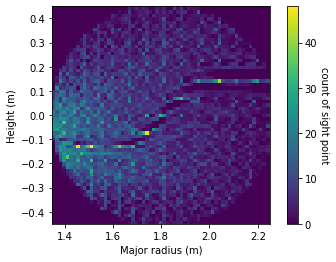

In [12]:
'''Check R'''
plt.axes().set_aspect('equal')
y = np.linspace(-0.45, 0.45, F_DIM)
x = np.linspace(1.35, 2.25, F_DIM)
X, Y = np.meshgrid(x, y)
plt.ylabel("Height (m)")
plt.xlabel("Major radius (m)")
plt.pcolor(X, Y, view_mat)
cbar = plt.colorbar()
cbar.set_label('count of sight point', rotation=270, labelpad=12)
# plt.savefig("viewmat.png")